<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/Wider_Wind_PCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install casadi chaospy

In [2]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
np.random.seed(3)

In [4]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

wx1 = 500
wx2 = 4100
wx3 = 4600

wh1 = 500
wh2 = 4100
wh3 = 4600

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
    A4 = 50
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    return ca.if_else(x_ <= wx1, B12,
           ca.if_else(x_ <= wx2, B23,
           ca.if_else(x_ <= wx3, B34, A4)))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
    B4 = 0
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    return ca.if_else(x_ <= wh1, B12,
           ca.if_else(x_ <= wh2, B23,
           ca.if_else(x_ <= wh3, B34, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def originalWindModel(x_, h_, k_):
    return wind_x(x_, k_), wind_h(x_, h_, k_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    dt = tf / N
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visulize_trajectory(u_opt, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    k_values = np.random.normal(1.0, 0.25, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, k)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    # ax2.set_xlabel("x [ft]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs t)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

In [96]:
def plot_pce_trajectories(res, tf=40, N=80):
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        plt.plot(x[j], h[j], label=f'PCE node {j+1}')
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(1,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 40        # final time [sec]
    N = 80         # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # # Integration using RK4
    # X_sym = ca.MX.sym("X", 5)
    # u_sym = ca.MX.sym("u")

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0.0)
    opti.subject_to(gamma_s[:, -1] <= 0.50)

    # for i in range(N):
    #     h_physical = h_s[:, i] * hscale
    #     h_mean = ca.mtimes(weights_dm, h_physical)
    #     deviation = hR - h_mean
    #     scaled_deviation = deviation / hscale
    #     J += dt * scaled_deviation**6

    #     for j, k_val in enumerate(nodes):
    #         tk = i * dt     # New line
    #         Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
    #         Uk = u[i]
    #         Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
    #         X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
    #         opti.subject_to(X_next == Xk_end)

    #     opti.subject_to(opti.bounded(-1, u_s[i], 1))
    #     alpha_i = alpha_s[:, i] * alphascale
    #     alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
    #     alpha_high_coeffs = alpha_pce_coeffs[1:]
    #     alpha_mean = ca.mtimes(weights_dm, alpha_i)
    #     std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

    #     opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
    #     opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)

    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.mtimes(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

## Compare Different Order of PCE

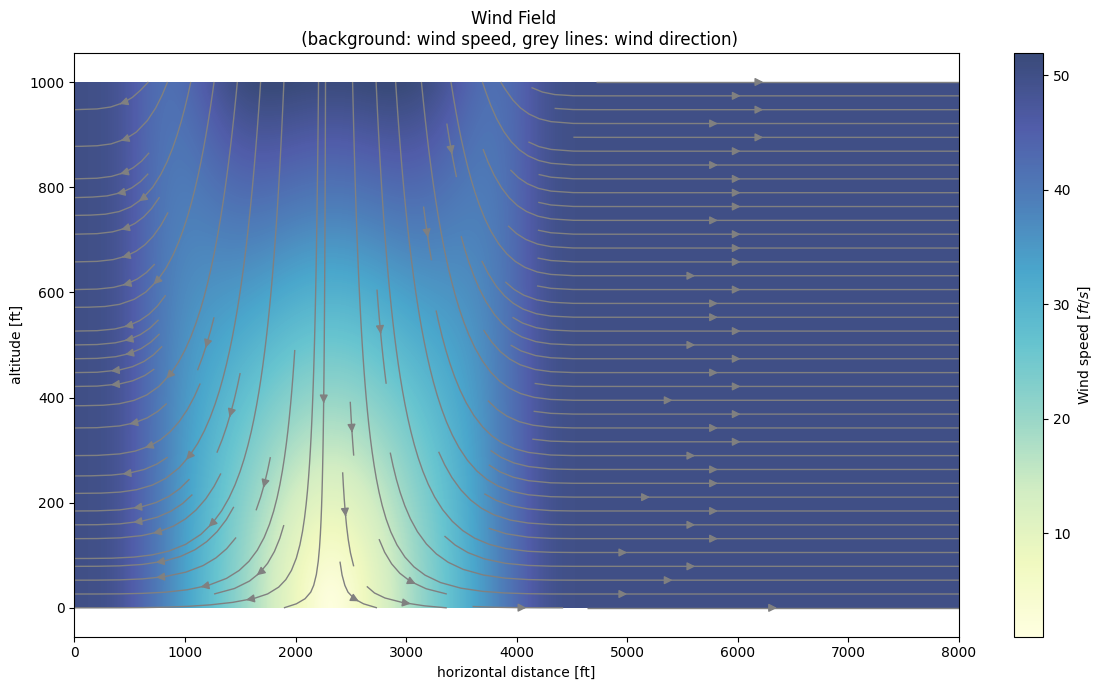

In [7]:
# --------- Wind Field ---------
k_value = 1   # wind intensity factor
x_range = np.linspace(0, 8000, 61)
h_range = np.linspace(0, 1000, 61)
X, H = np.meshgrid(x_range, h_range)

Wx = wind_x(X, k_value)
Wh = wind_h(X, H, k_value)
wind_strength = np.sqrt(Wx**2 + Wh**2)

# --------- Background ---------
plt.figure(figsize=(12, 7))
im = plt.imshow(wind_strength, extent=(x_range[0], x_range[-1], h_range[0], h_range[-1]),
                origin='lower', aspect='auto', cmap='YlGnBu', interpolation='bicubic', alpha=0.8)

plt.colorbar(im, label='Wind speed $[ft/s]$')

# --------- Wind Direction Streamlines ---------
plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')


plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title(f'Wind Field \n (background: wind speed, grey lines: wind direction)')
# plt.legend()
plt.tight_layout()
plt.show()

### Order 2

In [8]:
res2 = solve_ocp_pce(pce_order=2, k_mean=1.0, k_std=0.25)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.83ms ( 57.56us)   4.72ms ( 56.24us)        84
       nlp_g  | 484.39ms (  5.77ms) 466.62ms (  5.55ms)        84
  nlp_grad_f  |   8.36ms (109.97us)   8.27ms (108.81us)        76
   nlp_jac_g  |   2.63 s ( 34.59ms)   2.53 s ( 33.22ms)        76
       total  |   6.68 s (  6.68 s)   6.43 s (  6.43 s)         1


87.39558542261571


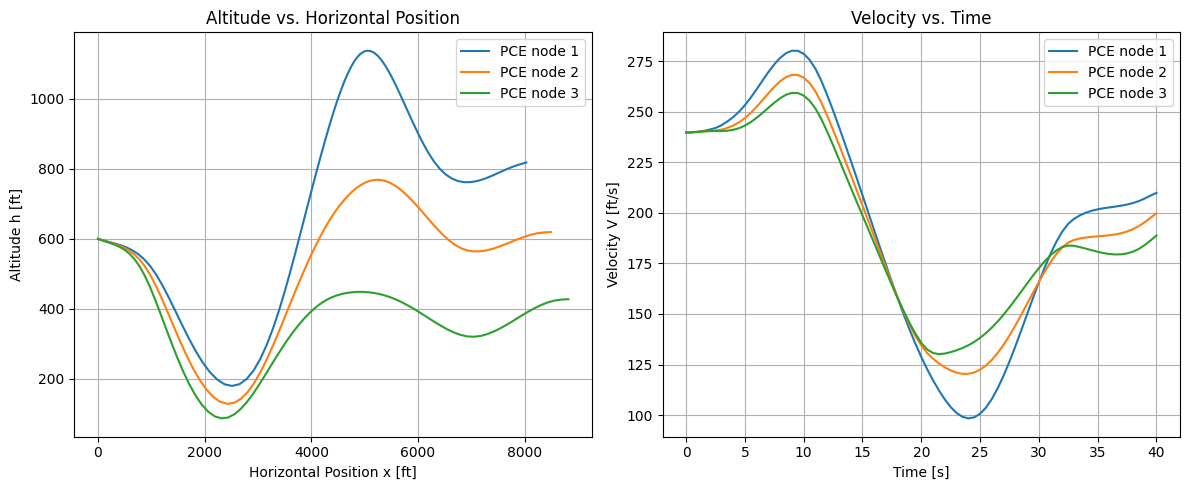

In [9]:
plot_pce_trajectories(res2)

1.9256145593999652
1.9063218715366255
2.0228481898934128
1.9165706356683052
1.9250991072367944


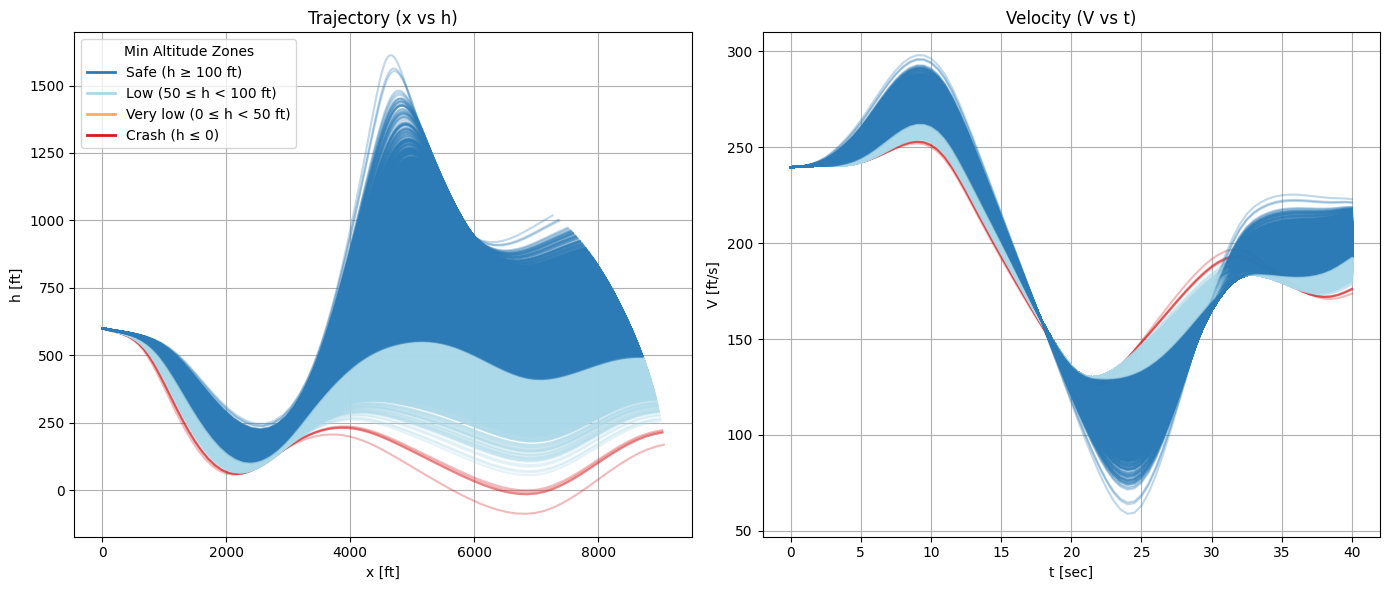

P(Under 100) = 0.1203
P(Under 50) = 0.0005
P(Under 0) = 0.0005


In [10]:
visulize_trajectory(res2["u"])

### Order 3

In [11]:
res3 = solve_ocp_pce(pce_order=3, k_mean=1.0, k_std=0.25)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.50ms ( 98.11us)  10.44ms ( 97.54us)       107
       nlp_g  | 765.09ms (  7.15ms) 733.20ms (  6.85ms)       107
  nlp_grad_f  |  19.07ms (202.83us)  17.94ms (190.83us)        94
   nlp_jac_g  |   4.09 s ( 43.52ms)   3.77 s ( 40.14ms)        94
       total  |   9.67 s (  9.67 s)   9.03 s (  9.03 s)         1


63.94603924399617


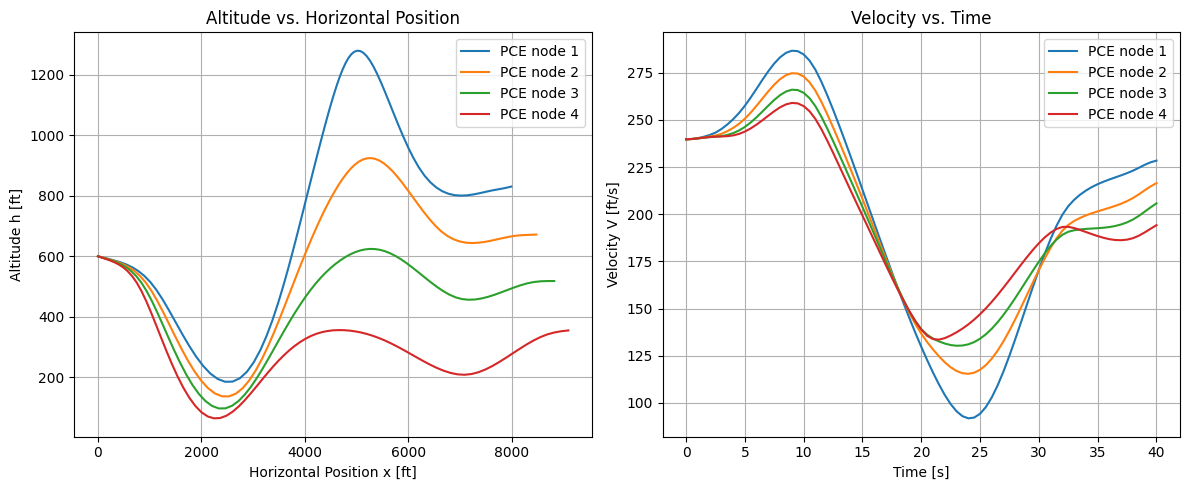

In [12]:
plot_pce_trajectories(res3)

2.091732386036801
1.8763892058930298


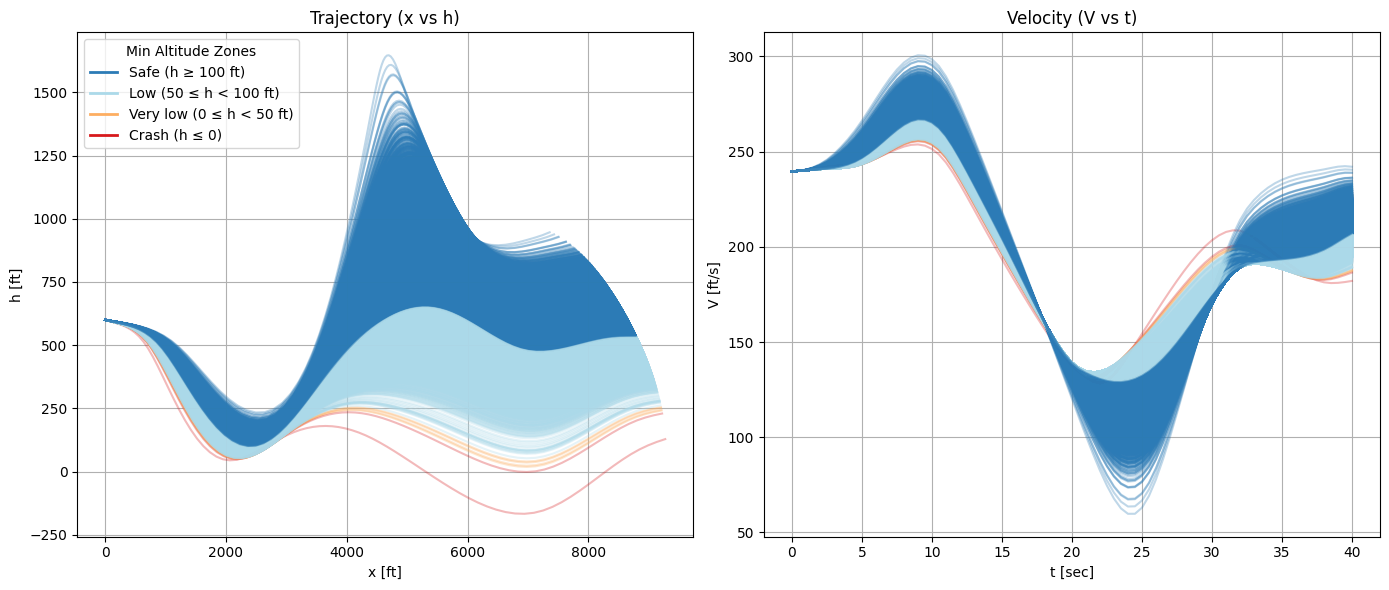

P(Under 100) = 0.2765
P(Under 50) = 0.0006
P(Under 0) = 0.0002


In [13]:
visulize_trajectory(res3["u"])

### Order 5

In [14]:
res5 = solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.54ms (285.20us)  18.39ms (282.99us)        65
       nlp_g  | 823.37ms ( 12.67ms) 760.02ms ( 11.69ms)        65
  nlp_grad_f  |  35.92ms (570.13us)  34.87ms (553.52us)        63
   nlp_jac_g  |   4.41 s ( 69.98ms)   4.17 s ( 66.14ms)        63
       total  |  12.47 s ( 12.47 s)  11.30 s ( 11.30 s)         1


-1565.7444571988426


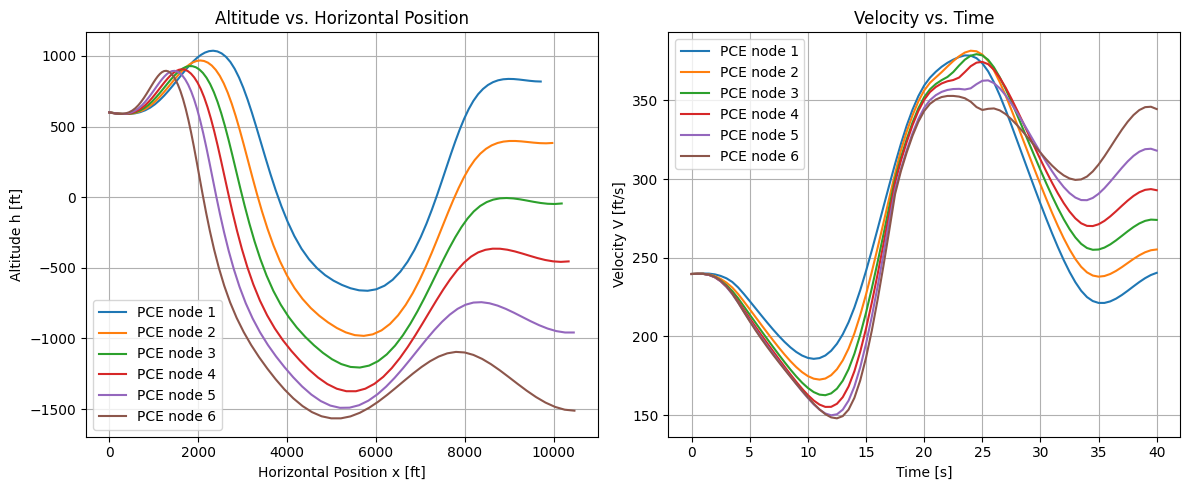

In [15]:
plot_pce_trajectories(res5)

流式输出内容被截断，只能显示最后 5000 行内容。
0.9835881166067195
0.9502022316917852
0.8728334631178011
1.131206729455398
0.791167952313282
1.2887893833573334
1.1808681055734123
0.8061953731104965
0.7505114354407858
1.3796476306977743
0.9845355089703083
0.6786815057731236
0.9688747879947234
0.3696145001322304
1.2540355622377568
0.6935416644330288
0.7052032251892134
1.1033627085322744
1.1301211191849956
0.9878325931838393
0.9096435030783283
0.7502024859538794
0.8496478079177582
0.6569118780600568
1.1866261454667553
1.2942406596092815
0.8092222548538113
0.3471828749917186
1.0171626878622655
1.3682937966150632
0.7010819990167392
1.199361131412437
0.9756346149401497
0.7521726448376902
1.4351199737802272
1.0980526634888343
0.8263585336495751
1.1028247435285141
1.0194355053707234
0.9643159387881708
1.1061861888929088
0.7805669736025294
1.0175102900412145
0.9005296038254362
1.0493580018520745
0.8227577827790908
1.1453147184853445
0.8571787005761418
1.0921449027976282
0.5998591433666146
0.9715575875680966
0.81108

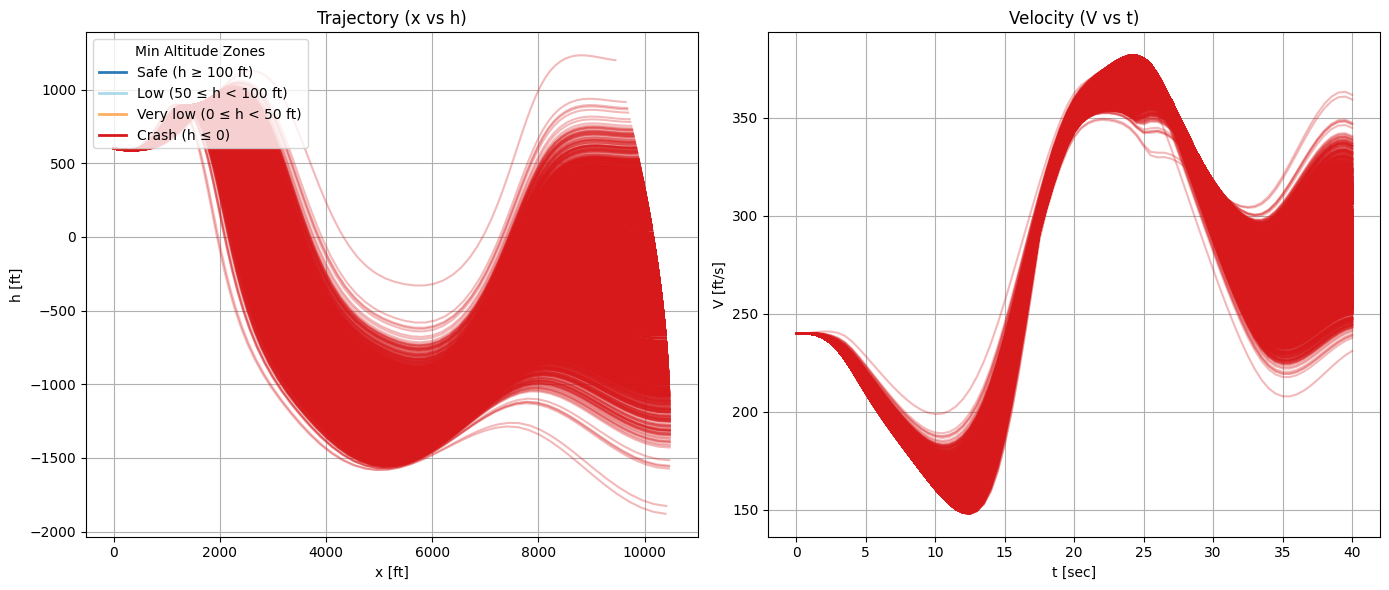

P(Under 100) = 1.0000
P(Under 50) = 1.0000
P(Under 0) = 1.0000


In [16]:
visulize_trajectory(res5["u"])

## Wider Wind

Wind width scaled by factor 1.1

In [114]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

wx1 = 500
wx2 = 4100 * 1.3
wx3 = 4600 * 1.3

wh1 = 500
wh2 = 4100 * 1.3
wh3 = 4600 * 1.3

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (wx3 - x_)**3 - b * (wx3 - x_)**4
    A4 = 50
    s1 = Smooth(x_, wx1-30, wx2+30)
    s2 = Smooth(x_, wx2-30, wx2+30)
    s3 = Smooth(x_, wx3-30, wx3+30)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    # return ca.if_else(x_ <= wx1, B12,
    #        ca.if_else(x_ <= wx2, B23,
    #        ca.if_else(x_ <= wx3, B34, A4)))
    return ca.if_else(x_ <= wx1, B12,
           ca.if_else(x_ <= wx2, B23, A4))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (wh3 - x_)**3 + e * (wh3 - x_)**4
    B4 = 0
    s1 = Smooth(x_, wh1-30, wh1+30)
    s2 = Smooth(x_, wh2-30, wh2+30)
    s3 = Smooth(x_, wh3-30, wh3+30)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    # return ca.if_else(x_ <= wh1, B12,
    #        ca.if_else(x_ <= wh2, B23,
    #        ca.if_else(x_ <= wh3, B34, B4)))
    return ca.if_else(x_ <= wh1, B12,
           ca.if_else(x_ <= wh2, B23, B4))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def originalWindModel(x_, h_, k_):
    return wind_x(x_, k_), wind_h(x_, h_, k_)

def C_L(alpha_):
    return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                      C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
def beta(t_):
    return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

def aircraft_ode(k_value):
    x_ = ca.MX.sym('x')
    h_ = ca.MX.sym('h')
    V_ = ca.MX.sym('V')
    gamma_ = ca.MX.sym('gamma')
    alpha_ = ca.MX.sym('alpha')

    u_ = ca.MX.sym('u')
    t_ = ca.MX.sym('t')

    T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
    D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
    L = 0.5 * rho * S * C_L(alpha_) * V_**2

    Wx, Wh = originalWindModel(x_, h_, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_], [ca.gradient(Wx, x_)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_, h_], [ca.gradient(Wh, x_)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_, h_], [ca.gradient(Wh, h_)])

    V_safe = ca.fmax(V_, 1e-3)

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )
    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )
    alpha_dot = u_

    y0 = ca.vertcat(x_, h_, V_, gamma_, alpha_)
    yk = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
    return ca.Function('f', [y0, u_, t_], [yk])

def rk4_step(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def reconstruct_trajectory(u_opt, k, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    dt = tf / N
    traj = {"x": [], "h": [], "V": [], "gamma": [], "alpha": [], "t": []}
    X = np.array([x0, h0, V0, gamma0, alpha0])

    f = aircraft_ode(k)

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(float(X[0]))
        traj["h"].append(float(X[1]))
        traj["V"].append(float(X[2]))
        traj["gamma"].append(float(X[3]))
        traj["alpha"].append(float(X[4]))
        traj["t"].append(t)
        X = rk4_step(f, X, u, t, dt)

    traj["x"].append(float(X[0]))
    traj["h"].append(float(X[1]))
    traj["V"].append(float(X[2]))
    traj["gamma"].append(float(X[3]))
    traj["alpha"].append(float(X[4]))
    traj["t"].append(t + dt)
    return traj

def visulize_trajectory(u_opt, x0=0, h0=600, V0=239.7, gamma0=-0.03925, alpha0=0.1283, tf=40, N=80):
    k_values = np.random.normal(1.0, 0.25, 10000)

    under_0, under_50, under_100 = 0, 0, 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for k in k_values:
        traj = reconstruct_trajectory(u_opt, k)

        if min(traj["h"]) < 1e-6:
            under_0 += 1
            print(k)
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
        elif min(traj["h"]) < 50:
            under_50 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
        elif min(traj["h"]) < 100:
            under_100 += 1
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
        else:
            ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
            ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

    ax1.set_xlabel("x [ft]")
    ax1.set_ylabel("h [ft]")
    ax1.set_title("Trajectory (x vs h)")
    ax1.grid(True)
    legend_elements = [
        Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
        Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
        Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
        Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

    ax2.set_xlabel("t [sec]")
    # ax2.set_xlabel("x [ft]")
    ax2.set_ylabel("V [ft/s]")
    ax2.set_title("Velocity (V vs t)")
    ax2.grid(True)
    # ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
    print(f"P(Under 0) = {under_0/len(k_values):.4f}")

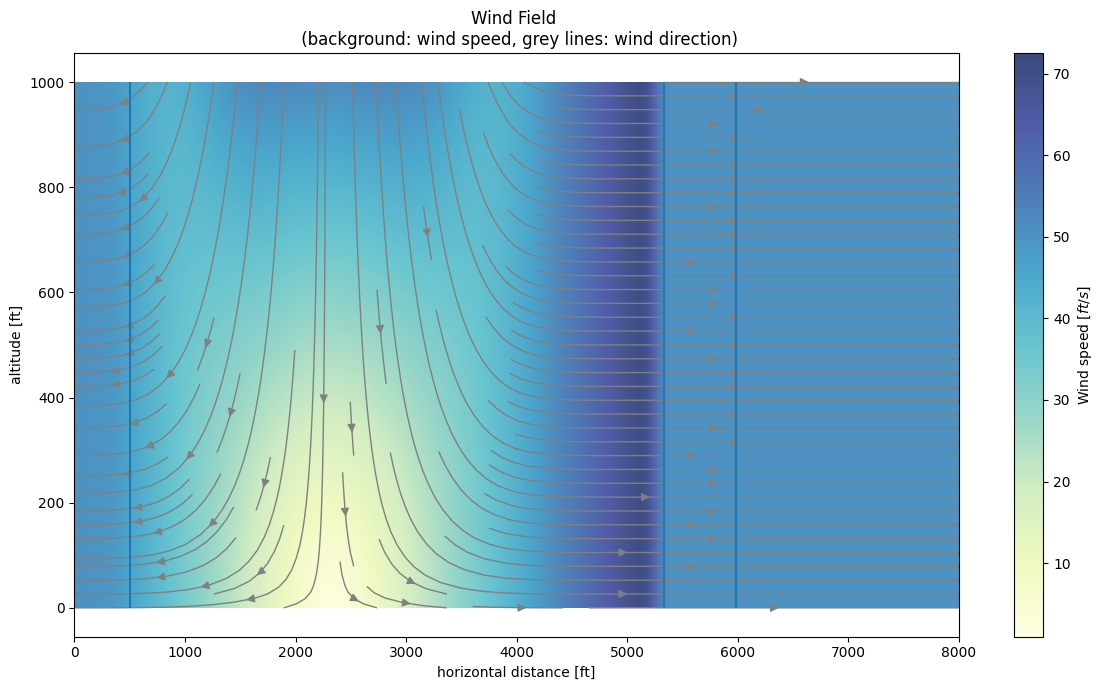

In [115]:
# --------- Wind Field ---------
k_value = 1   # wind intensity factor
x_range = np.linspace(0, 8000, 61)
h_range = np.linspace(0, 1000, 61)
X, H = np.meshgrid(x_range, h_range)

Wx = wind_x(X, k_value)
Wh = wind_h(X, H, k_value)
wind_strength = np.sqrt(Wx**2 + Wh**2)

# --------- Background ---------
plt.figure(figsize=(12, 7))
im = plt.imshow(wind_strength, extent=(x_range[0], x_range[-1], h_range[0], h_range[-1]),
                origin='lower', aspect='auto', cmap='YlGnBu', interpolation='bicubic', alpha=0.8)

plt.colorbar(im, label='Wind speed $[ft/s]$')

# --------- Wind Direction Streamlines ---------
plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.3, arrowsize=1.2, arrowstyle='-|>')

plt.vlines(wx1, 0, 1000)
plt.vlines(wx2, 0, 1000)
plt.vlines(wx3, 0, 1000)


plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title(f'Wind Field \n (background: wind speed, grey lines: wind direction)')
# plt.legend()
plt.tight_layout()
plt.show()

In [116]:
def plot_pce_trajectories(res, tf=40, N=80):
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        plt.plot(x[j], h[j], label=f'PCE node {j+1}')
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()
    x_range = np.linspace(0, 10000, 61)
    h_range = np.linspace(0, 1000, 61)
    plt.streamplot(x_range, h_range, Wx, Wh, color='grey', linewidth=1, density=1.1, arrowsize=1.2, arrowstyle='-|>')

    # V-t plot
    plt.subplot(1,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [109]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 50        # final time [sec]
    N = 100        # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)
    opti.subject_to(gamma_s[:, -1] >= 0)

    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

            alpha_i = alpha_s[:, i] * alphascale
            alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
            alpha_high_coeffs = alpha_pce_coeffs[1:]
            alpha_mean = ca.mtimes(weights_dm, alpha_i)
            std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 0,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

### Order 1

In [117]:
res_w_1 = solve_ocp_pce(pce_order=1)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.11ms ( 29.21us)   8.86ms ( 28.41us)       312
       nlp_g  |   1.31 s (  4.18ms)   1.23 s (  3.94ms)       312
  nlp_grad_f  |  14.02ms ( 58.18us)  13.69ms ( 56.82us)       241
   nlp_jac_g  |   5.75 s ( 23.85ms)   5.31 s ( 22.04ms)       241
       total  |  18.03 s ( 18.03 s)  16.62 s ( 16.62 s)         1


5.645562150050718


ValueError: x and y must have same first dimension, but have shapes (81,) and (101,)

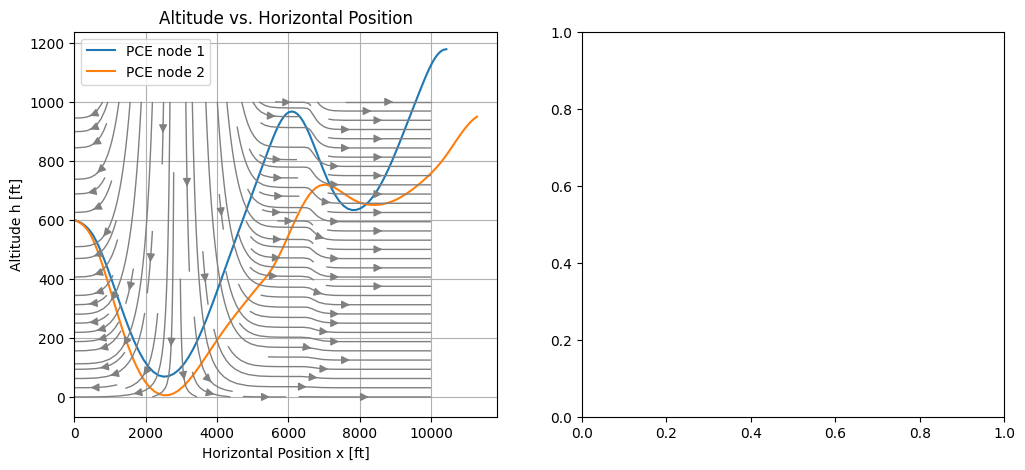

In [111]:
plot_pce_trajectories(res_w_1)

### Order 2

In [70]:
res_w_2 = solve_ocp_pce(pce_order=2)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 227.06ms ( 49.73us) 216.94ms ( 47.51us)      4566
       nlp_g  |  26.76 s (  5.86ms)  24.68 s (  5.41ms)      4566
  nlp_grad_f  |  97.85ms (102.46us)  94.98ms ( 99.46us)       955
   nlp_jac_g  |  34.66 s ( 34.73ms)  31.27 s ( 31.34ms)       998
       total  | 120.47 s (120.47 s) 108.69 s (108.69 s)         1
Violated constraints (tol 0), in order of declaration:
------- i = 0/1710 ------ 
0 <= 6.89726e-26 <= 0 (viol 6.89726e-26)
Opti constraint of shape 3x1, called from /content/<ipython-input-68-1933605470>:146 in solve_ocp_pce
At nonzero 0, part 0.
------- i = 1/1710 ------ 
0 <= -1.58558e-23 <= 0 (viol 1.58558e-23)
Opti constraint of shape 3x1, called from /content/<ipython-input-68-1933605470>:146 in solve_ocp_pce
At nonzero 1, part 0.
------- i = 2/1710 ------ 
0 <= 2.56816e-23 <= 0 (viol 2.56816e-23)
Opti constraint of shape 3x1, called from /content/<ipython-input-68-1933605470>:146 in solve_oc

-142.44679498202726


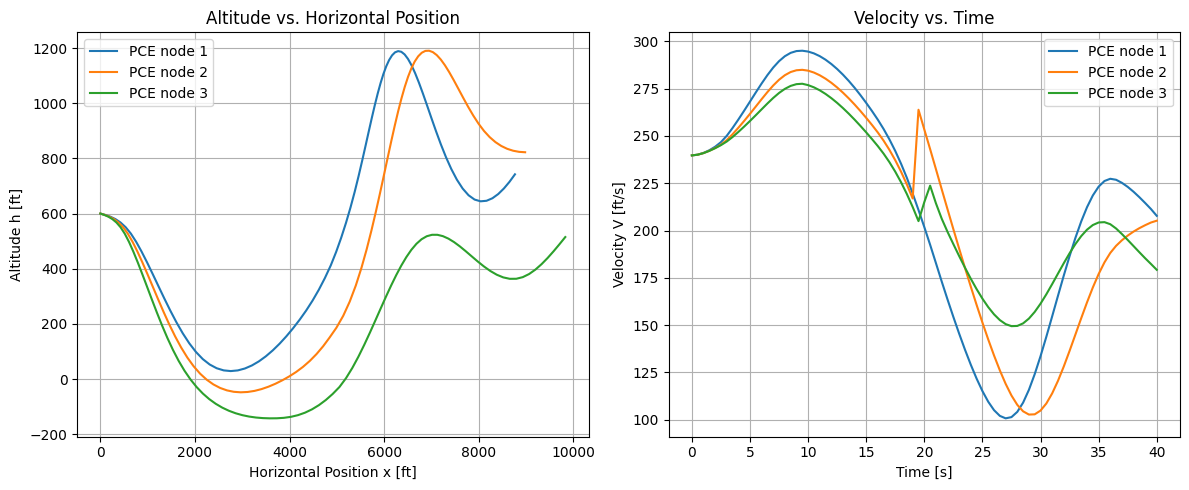

In [93]:
plot_pce_trajectories(res_w_2)

1.5978208465146944
1.2002161963733655
1.3981400345711572
1.2386780583695327
1.2577897338075257
1.3452213623877165
1.2785212720333452
1.2860499023217096
1.2546047017233524
1.2570746744319363
1.3842242342211666
1.1964628727543332
1.3602511067578988
1.6051244849459936
1.370174784598856
1.5084274881836122
1.2401570375725008
1.2610890087534665
1.2029536470961506
1.2474315211061935
1.649683517570101
1.2510062097345682
1.4414256570920063
1.363493274107698
1.3495736361560386
1.5075468518159387
1.3939143862932362
1.348809493303229
1.2800378265512715
1.2180164015247965
1.1806640287816665
1.3285806800352815
1.4502810486976063
1.4262667154641537
1.2126220230832319
1.2551529916060917
1.4057772792684804
1.3680771714724653
1.198520437964328
1.3058463935403575
1.3505798986134292
1.2684849337279351
1.4936041080541218
1.2860019332582162
1.4228919655170489
1.243161927144127
1.4926293479962929
1.3483871849786686
1.4607476467772424
1.6304122049221481
1.3120110137348817
1.243413794662243
1.4713440238893958


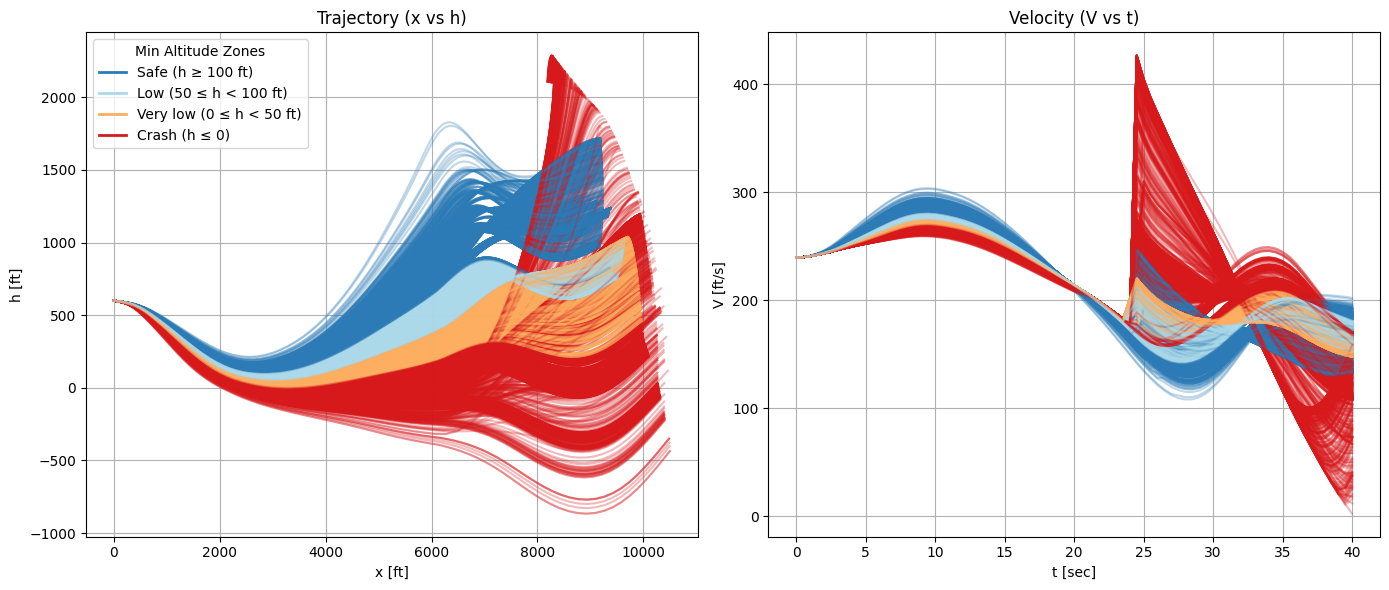

P(Under 100) = 0.8749
P(Under 50) = 0.5619
P(Under 0) = 0.2414


In [53]:
visulize_trajectory(res_w_2["u"])

### Order 3

In [23]:
res_w_3 = solve_ocp_pce(pce_order=3)

流式输出内容被截断，只能显示最后 5000 行内容。
At nonzero 0, part 0.
------- i = 769/2276 ------ 
0 <= -1.36312e-07 <= 0 (viol 1.36312e-07)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 1, part 0.
------- i = 770/2276 ------ 
0 <= -5.70287e-09 <= 0 (viol 5.70287e-09)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 2, part 0.
------- i = 771/2276 ------ 
0 <= 6.76754e-11 <= 0 (viol 6.76754e-11)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 3, part 0.
------- i = 772/2276 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 4, part 0.
------- i = 774/2276 ------ 
0 <= 3.64198e-08 <= 0 (viol 3.64198e-08)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 0, part 0.

-148.78468056167603


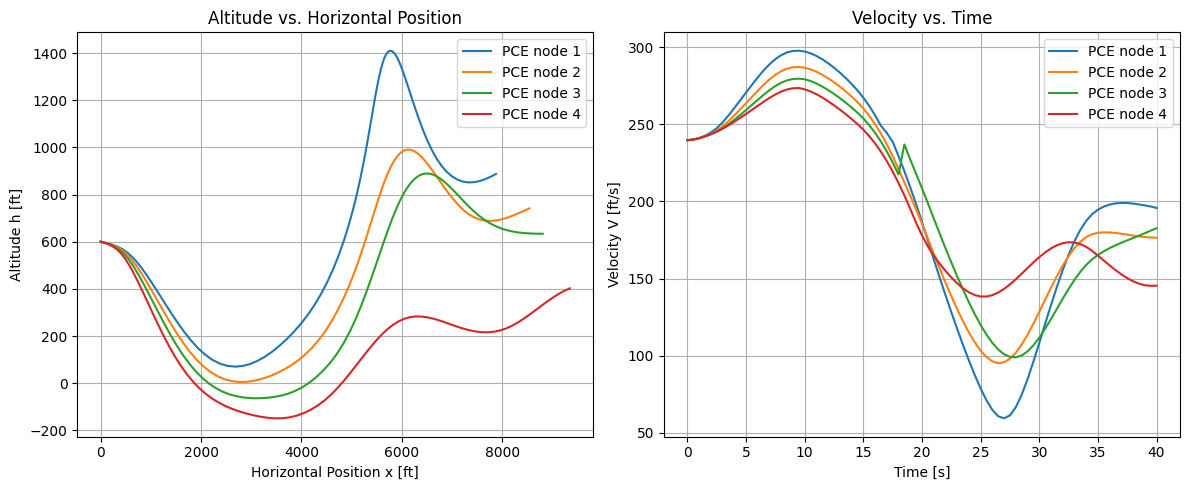

In [24]:
plot_pce_trajectories(res_w_3)

流式输出内容被截断，只能显示最后 5000 行内容。
1.0893902972063256
1.0298791668389282
1.4285278044357281
1.0241433750096802
0.8790985276846582
1.3526580890250017
1.208868808117602
1.2501343953634163
1.176916867584878
1.0045484830002844
0.984779577743989
1.163514328010662
1.1241409333700263
1.0060927279290288
1.1349442896962367
1.2815145289905587
1.2760098175776962
0.9539817485154442
1.008159301941057
1.0442199546899413
0.9648664287680517
0.8737757997820284
0.9893575502952082
1.1306332029371737
1.0688807552450303
1.147415886589687
1.637489041525114
1.0788593619613382
1.1141172201075284
0.9727575222986267
0.8794992839737581
1.473371259292359
0.9531308806882149
1.027289878228675
1.1050658428009772
1.1785901906854956
0.9644176479599683
1.0866776350567464
1.4238912084618482
0.9871501588852054
0.9007090146177089
1.0785935781734453
1.2208502676806132
1.3966080076137728
0.9076253525701188
1.3493755440934911
1.26246756598923
1.0999619875977011
0.9459478228351411
1.1349983241191197
1.0027622283261535
1.0184360560540

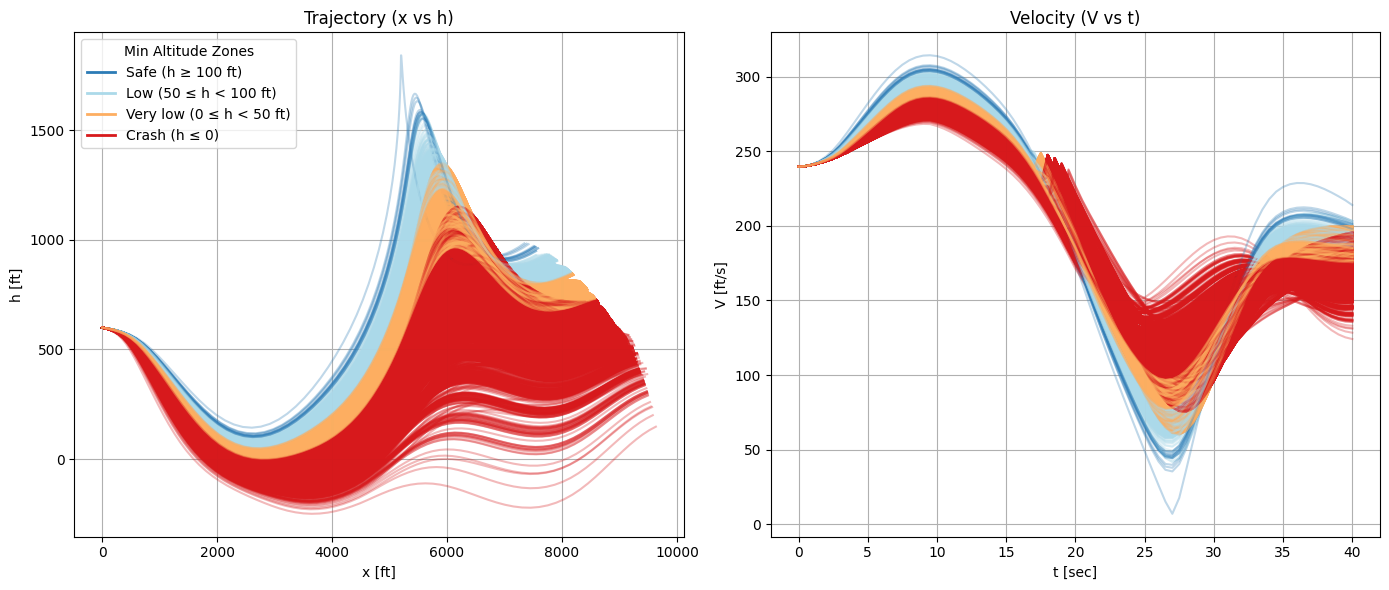

P(Under 100) = 0.9986
P(Under 50) = 0.9649
P(Under 0) = 0.7344


In [25]:
visulize_trajectory(res_w_3["u"])

### Order 5

In [26]:
res_w_5 = solve_ocp_pce(pce_order=5)

流式输出内容被截断，只能显示最后 5000 行内容。
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 2, part 0.
------- i = 2061/3414 ------ 
0 <= 1.9984e-15 <= 0 (viol 1.9984e-15)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 3, part 0.
------- i = 2062/3414 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 4, part 0.
------- i = 2063/3414 ------ 
-1 <= 1 <= 1 (viol 9.99858e-09)
Opti constraint of shape 1x1, called from /content/<ipython-input-19-1821477471>:180 in solve_ocp_pce
------- i = 2064/3414 ------ 
0 <= 4.09273e-12 <= 0 (viol 4.09273e-12)
Opti constraint of shape 5x1, called from /content/<ipython-input-19-1821477471>:178 in solve_ocp_pce
At nonzero 0, part 0.
------- i = 2065/3414 ------ 
0 <= 1.19371e-12 <= 0 (viol 1.19371e-12)
Opti constraint of shape 5x1, called from /content/

-1254.498469404794


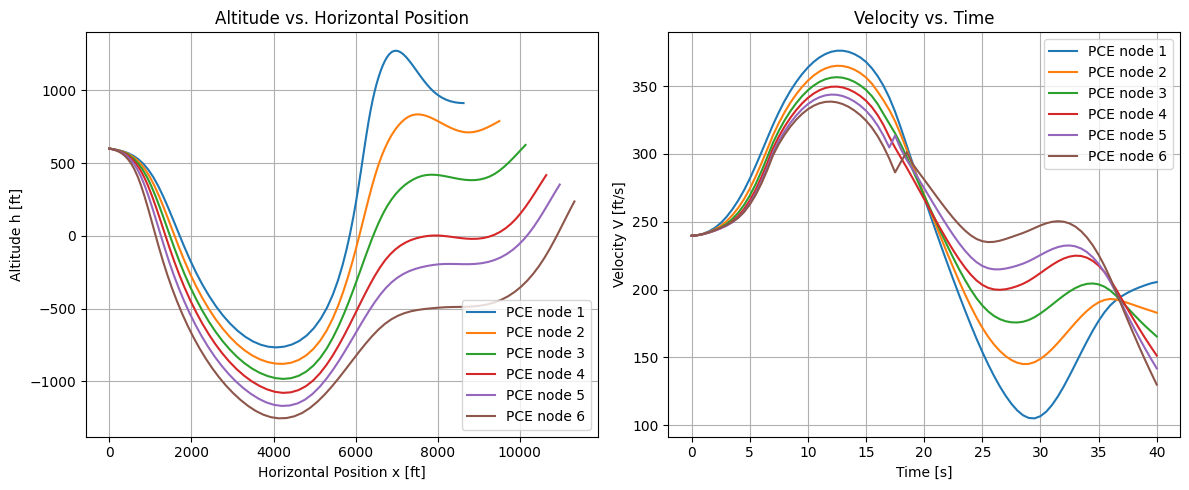

In [27]:
plot_pce_trajectories(res_w_5)

流式输出内容被截断，只能显示最后 5000 行内容。
0.9143681948700007
0.9738130691546814
1.335918468027829
0.6515003974087541
0.8582298866342308
1.0417475586252976
0.9705497859962133
1.10546190586991
0.760790534611699
1.2651288119004664
1.1908724026675808
0.6252854710885136
0.8989087032902117
1.0263421997008453
0.9763281993006708
0.7593788601699996
1.3278741073533418
1.02740327328785
0.8533123875873814
0.970967590899388
0.6085456281507704
1.0426994152532532
1.2888583317077988
0.8040940334810138
1.1116423433352305
1.171161819457171
0.6345478828551125
0.9092836606508886
1.4025608327384131
0.7010577471256456
1.5765310441098515
0.9090550399021207
1.0787096155358609
1.083903848986862
0.934734384109591
0.6015391348207457
0.6505493753804268
1.2583445640912434
0.7995496867994074
0.8541925448714492
1.0673575998062015
1.1028843103497827
1.1098238517117138
1.0083551802338508
1.4626499666345252
1.1575189016459753
0.956179325050982
1.1010268280951816
0.7326517503428491
1.3917677771073529
0.9614659925918365
1.4716610030133

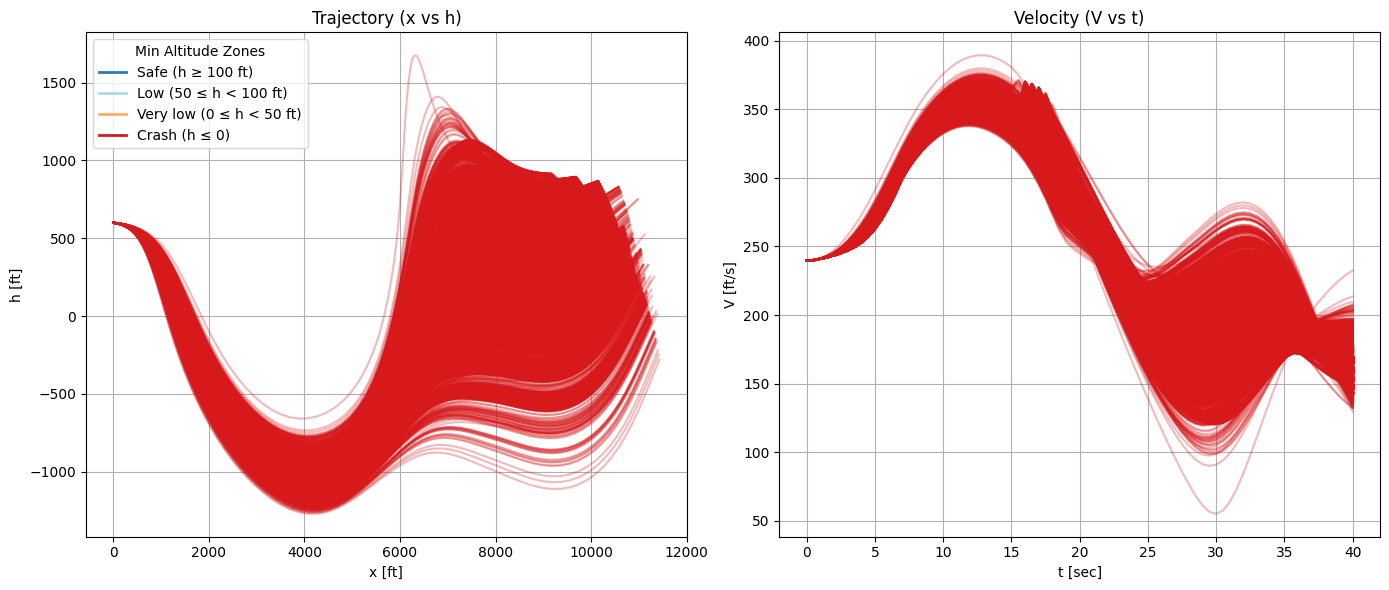

P(Under 100) = 1.0000
P(Under 50) = 1.0000
P(Under 0) = 1.0000


In [28]:
visulize_trajectory(res_w_5["u"])